In [1]:
%cd ~/repo/protein-transfer

/home/t-fli/repo/protein-transfer


In [2]:
%load_ext blackcellmagic

In [7]:
"""Script for running pytorch models"""

from __future__ import annotations

import os

import torch
import torch.nn as nn

from sklearn.metrics import ndcg_score
from scipy.stats import spearmanr

from scr.params.sys import RAND_SEED, DEVICE
from scr.params.emb import TRANSFORMER_INFO

from scr.preprocess.data_process import split_protrain_loader
from scr.model.pytorch_model import LinearRegression
from scr.model.train_test import train, test
from scr.encoding.encoding_classes import AbstractEncoder, ESMEncoder
from scr.vis.learning_vis import plot_lc
from scr.utils import get_folder_file_names, pickle_save

def run_pytorch(
    dataset_path: str,
    encoder_class: AbstractEncoder,
    encoder_name: str,
    embed_layer: int,
    embed_batch_size: int = 128,
    flatten_emb: bool | str = False,
    embed_path: str | None = None,
    seq_start_idx: bool | int = False,
    seq_end_idx: bool | int = False,
    loader_batch_size: int = 64,
    worker_seed: int = RAND_SEED,
    learning_rate: float = 1e-4,
    lr_decay: float = 0.1,
    epochs: int = 100,
    device: torch.device | str = DEVICE,
    all_result_folder: str = "results/train_val_test",
    **encoder_params,
) -> dict:

    """
    A function for running pytorch model

    Args:
    - dataset_path: str, full path to the dataset, in pkl or panda readable format
        columns include: sequence, target, set, validation, mut_name (optional), mut_numb (optional)
    - encoder_class: AbstractEncoder, the encoder class
    - encoder_name: str, the name of the encoder
    - embed_layer: int, the layer number of the embedding
    - embed_batch_size: int, set to 0 to encode all in a single batch
    - flatten_emb: bool or str, if and how (one of ["max", "mean"]) to flatten the embedding
    - embed_path: str = None, path to presaved embedding
    - seq_start_idx: bool | int = False, the index for the start of the sequence
    - seq_end_idx: bool | int = False, the index for the end of the sequence
    - loader_batch_size: int, the batch size for train, val, and test dataloader
    - worker_seed: int, the seed for dataloader
    - learning_rate: float
    - lr_decay: float, factor by which to decay LR on plateau
    - epochs: int, number of epochs to train for
    - device: torch.device or str
    - all_result_folder: str = "results/train_val_test", the parent folder for all results
    - encoder_params: kwarg, additional parameters for encoding

    Returns:
    - result_dict: dict, with the keys and dict values
        "losses": {"train_losses": np.ndarray, "val_losses": np.ndarray}
        "train": {"mse": float, 
                  "pred": np.ndarray,
                  "true": np.ndarray,
                  "ndcg": float,
                  "rho": SpearmanrResults(correlation=float, pvalue=float)}
        "val":   {"mse": float, 
                  "pred": np.ndarray,
                  "true": np.ndarray,
                  "ndcg": float,
                  "rho": SpearmanrResults(correlation=float, pvalue=float)}
        "test":  {"mse": float, 
                  "pred": np.ndarray,
                  "true": np.ndarray,
                  "ndcg": float,
                  "rho": SpearmanrResults(correlation=float, pvalue=float)}

    """

    train_loader, val_loader, test_loader = split_protrain_loader(
        dataset_path=dataset_path,
        encoder_class=encoder_class,
        encoder_name=encoder_name,
        embed_layer=embed_layer,
        embed_batch_size=embed_batch_size,
        flatten_emb=flatten_emb,
        embed_path=embed_path,
        seq_start_idx=seq_start_idx,
        seq_end_idx=seq_end_idx,
        subset_list=["train", "val", "test"],
        loader_batch_size=loader_batch_size,
        worker_seed=worker_seed,
        **encoder_params,
    )

    model = LinearRegression(input_dim=TRANSFORMER_INFO[encoder_name][0], output_dim=1)
    model.to(device, non_blocking=True)
    
    criterion = nn.MSELoss()
    criterion.to(device, non_blocking=True)

    train_losses, val_losses = train(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        criterion=criterion,
        learning_rate=learning_rate,
        lr_decay=lr_decay,
        epochs=epochs,
    )

    # record the losses
    result_dict = {"losses": {"train_losses": train_losses, "val_losses": val_losses}}

    plot_lc(
        train_losses=train_losses,
        val_losses=val_losses,
        dataset_path=dataset_path,
        encoder_name=encoder_name,
        embed_layer=embed_layer,
        flatten_emb=flatten_emb,
    )

    # now test the model with the test data
    for subset, loader in zip(
        ["train", "val", "test"], [train_loader, val_loader, test_loader]
    ):
        mse, pred, true = test(
            model=model, loader=loader, device=device, criterion=criterion
        )

        result_dict[subset] = {
            "mse": mse,
            "pred": pred,
            "true": true,
            "ndcg": ndcg_score(true[None, :], pred[None, :]),
            "rho": spearmanr(true, pred),
        }

    dataset_subfolder, file_name = get_folder_file_names(
        parent_folder=all_result_folder,
        dataset_path=dataset_path,
        encoder_name=encoder_name,
        embed_layer=embed_layer,
        flatten_emb=flatten_emb,
    )

    print(f"Saving results for {file_name} to: {dataset_subfolder}...")
    pickle_save(
        what2save=result_dict,
        where2save=os.path.join(dataset_subfolder, file_name + ".pkl"),
    )

    return result_dict

In [10]:
dataset_path="data/proeng/gb1/two_vs_rest.pkl"
encoder_class=ESMEncoder
encoder_name="esm1b_t33_650M_UR50S"
embed_layer=33
flatten_emb="mean"
seq_end_idx=56
learning_rate = 0.001
loader_batch_size = 1024
epochs = 100
device = DEVICE
all_result_folder = "results/train_val_test"

Loading esm1b_t33_650M_UR50S using 33 layer embedding


Using cache found in /home/t-fli/.cache/torch/hub/facebookresearch_esm_main
100%|██████████| 3/3 [00:52<00:00, 17.58s/it]
Using cache found in /home/t-fli/.cache/torch/hub/facebookresearch_esm_main


Loading esm1b_t33_650M_UR50S using 33 layer embedding


100%|██████████| 1/1 [00:05<00:00,  5.28s/it]
Using cache found in /home/t-fli/.cache/torch/hub/facebookresearch_esm_main


Loading esm1b_t33_650M_UR50S using 33 layer embedding


100%|██████████| 9/9 [00:00<00:00, 174.54it/s]


[    1] loss: 1.117
[    1] loss: 1.035
[    9] loss: 1.909
Saving results for esm1b_t33_650M_UR50S-layer_33-mean to: results/train_val_test/proeng/gb1/two_vs_rest...


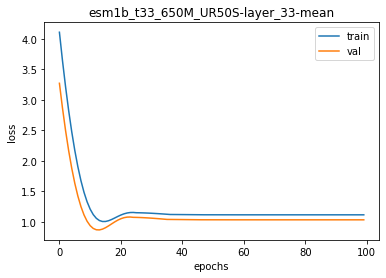

In [11]:
result_dict = run_pytorch(
    dataset_path=dataset_path,
    encoder_class=ESMEncoder,
    encoder_name=encoder_name,
    embed_layer=embed_layer,
    flatten_emb=flatten_emb,
    seq_end_idx=seq_end_idx,
    learning_rate=learning_rate,
    epochs=epochs,
    device=DEVICE,
    loader_batch_size=loader_batch_size,
    all_result_folder="results/train_val_test")